# Experiment: aerodynamic instability

Here I'll work on the experiment of chapter 6 of the ODE book I'm following.

v_c = sqrt(52/6). If v > v_c we get unstable solutions, if v < v_c the solutions are stable.

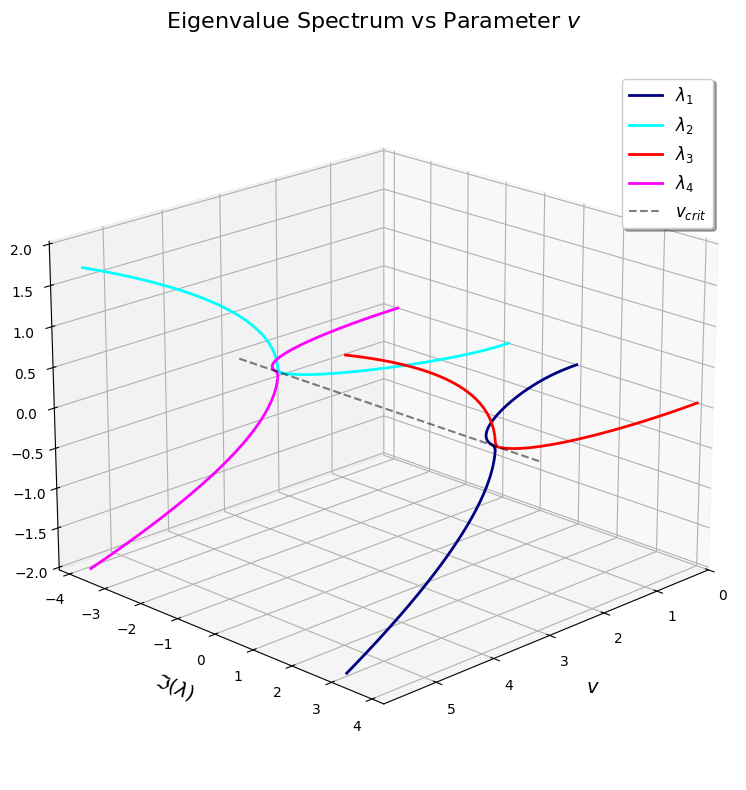

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple
import warnings
from dataclasses import dataclass

@dataclass
class EigenBranch:
    """Class to store and track eigenvalue branches."""
    value: complex
    branch_type: str  # 'outer' or 'inner'
    sign: int        # +1 or -1

def compute_sqrt_with_tracking(z: complex, prev_value: complex = None) -> complex:
    """
    Compute square root while maintaining continuity with previous value.
    
    Args:
        z (complex): Value to compute square root of
        prev_value (complex): Previous square root value for continuity
        
    Returns:
        complex: Square root value maintaining continuity
    """
    # Compute both possible square root values
    sqrt1 = np.sqrt(z)
    sqrt2 = -sqrt1
    
    if prev_value is None:
        return sqrt1
        
    # Choose the value that maintains continuity
    if abs(sqrt1 - prev_value) < abs(sqrt2 - prev_value):
        return sqrt1
    return sqrt2

def compute_eigenvalues(v: float, prev_values: List[EigenBranch] = None) -> List[EigenBranch]:
    """
    Compute the four eigenvalues for a given value of v with branch tracking.
    
    Args:
        v (float): The parameter value
        prev_values (List[EigenBranch]): Previous eigenvalues for continuity
        
    Returns:
        List[EigenBranch]: The four eigenvalues with branch information
    """
    v = complex(v)
    discriminant = 52 - 6 * v**2
    
    # For the outer square root (sqrt(-8 ± sqrt(discriminant)))
    if prev_values is None:
        # Initial computation without previous values
        sqrt_discr = np.sqrt(discriminant + 0j)
        
        # Compute both outer branches
        outer1 = np.sqrt(-8 + sqrt_discr)
        outer2 = np.sqrt(-8 - sqrt_discr)
        
        return [
            EigenBranch(outer1, 'outer', 1),
            EigenBranch(-outer1, 'outer', -1),
            EigenBranch(outer2, 'outer', 1),
            EigenBranch(-outer2, 'outer', -1)
        ]
    else:
        # Compute with continuity
        sqrt_discr = compute_sqrt_with_tracking(
            discriminant + 0j,
            prev_values[0].value**2 + 8  # Use previous value to track the branch
        )
        
        # Track both outer branches separately
        outer1 = compute_sqrt_with_tracking(-8 + sqrt_discr, prev_values[0].value)
        outer2 = compute_sqrt_with_tracking(-8 - sqrt_discr, prev_values[2].value)
        
        return [
            EigenBranch(outer1, 'outer', 1),
            EigenBranch(-outer1, 'outer', -1),
            EigenBranch(outer2, 'outer', 1),
            EigenBranch(-outer2, 'outer', -1)
        ]

def generate_eigenvalue_data(v_min: float, v_max: float, 
                           num_points: int = 2000) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Generate eigenvalue data over a range of v values with branch tracking.
    
    Args:
        v_min (float): Minimum value of v
        v_max (float): Maximum value of v
        num_points (int): Number of points to evaluate
        
    Returns:
        Tuple[np.ndarray, List[np.ndarray]]: v values and list of eigenvalue arrays
    """
    v_values = np.linspace(v_min, v_max, num_points)
    eigenvalues = [np.zeros(num_points, dtype=complex) for _ in range(4)]
    
    # Initial computation
    prev_branches = None
    
    # Compute eigenvalues for each v with branch tracking
    for i, v in enumerate(v_values):
        branches = compute_eigenvalues(v, prev_branches)
        for j in range(4):
            eigenvalues[j][i] = branches[j].value
        prev_branches = branches
            
    return v_values, eigenvalues

def create_3d_plot(v_values: np.ndarray, eigenvalues: List[np.ndarray], 
                  v_crit: float) -> plt.Figure:
    """
    Create a 3D visualization of the eigenvalues.
    
    Args:
        v_values (np.ndarray): Array of v values
        eigenvalues (List[np.ndarray]): List of eigenvalue arrays
        v_crit (float): Critical value of v
        
    Returns:
        plt.Figure: The matplotlib figure object
    """
    fig = plt.figure(figsize=(12, 8), dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['navy', 'cyan', 'red', 'magenta']
    labels = ['$\\lambda_{}$'.format(i+1) for i in range(4)]
    
    # Plot each eigenvalue curve
    for i, (eig, color, label) in enumerate(zip(eigenvalues, colors, labels)):
        ax.plot(v_values, eig.imag, eig.real, 
                color=color, 
                linewidth=2, 
                label=label)
    
    # Add a vertical line at v_crit
    ax.plot([v_crit, v_crit], 
            [min(min(eig.imag) for eig in eigenvalues), 
             max(max(eig.imag) for eig in eigenvalues)],
            [0, 0], 
            'k--', 
            alpha=0.5,
            label='$v_{crit}$')
    
    # Customize the appearance
    ax.set_xlabel('$v$', fontsize=14, labelpad=10)
    ax.set_ylabel('$\\Im(\\lambda)$', fontsize=14, labelpad=10)
    ax.set_zlabel('$\\Re(\\lambda)$', fontsize=14, labelpad=10)
    ax.set_title('Eigenvalue Spectrum vs Parameter $v$', fontsize=16, pad=20)
    
    # Set axis limits with margin
    margin = 0.1
    ax.set_xlim([0, v_crit * 2])
    y_min = min(min(eig.imag) for eig in eigenvalues)
    y_max = max(max(eig.imag) for eig in eigenvalues)
    z_min = min(min(eig.real) for eig in eigenvalues)
    z_max = max(max(eig.real) for eig in eigenvalues)
    
    ax.set_ylim([y_min * (1 + margin), y_max * (1 + margin)])
    ax.set_zlim([z_min * (1 + margin), z_max * (1 + margin)])
    
    # Enhance grid and viewing angle
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.view_init(elev=20, azim=45)
    
    # Add legend with background
    ax.legend(loc='upper right', fontsize=12, 
             bbox_to_anchor=(0.98, 0.98),
             bbox_transform=ax.transAxes,
             fancybox=True, 
             shadow=True)
    
    return fig

def main():
    """Main function to generate and display the plot."""
    warnings.filterwarnings('ignore')
    
    # Define constants
    V_CRIT = np.sqrt(52 / 6)
    
    # Generate data with increased resolution around v_crit
    v_values, eigenvalues = generate_eigenvalue_data(0, 2 * V_CRIT)
    
    # Create and show the plot
    fig = create_3d_plot(v_values, eigenvalues, V_CRIT)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()